<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/ART_Target_Label_Flipping_Attack_Using_Dirty_Label_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.23.5

In [ ]:
'''
install library which is not already installed
'''
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets
!pip install tensorflow==2.9

In [ ]:
import numpy as np
import librosa
import logging

logging.basicConfig(level=logging.INFO)  # Set the desired logging level


class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [ ]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

import glob
import shutil
import urllib.request
import requests
import zipfile
import pathlib
from zipfile import ZipFile
from IPython import display

import random
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

# Set the seed value for experiment reproducibility.
seed = 47
tf.random.set_seed(seed)
np.random.seed(seed)

## Dataset [link dataset HugginFace](https://huggingface.co/datasets?sort=trending&search=fluent)

In [ ]:
# install datasets
%%capture
!pip install datasets==1.18.3
from datasets import load_dataset

In [ ]:
# Let's import the library. We typically only need at most two methods:
from datasets import list_datasets, load_dataset
from pprint import pprint

In [ ]:
from tqdm.notebook import tqdm
import os; import psutil; import timeit

#loading the dataset from 'datasets' library
timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

# TIMIT dataset

In [ ]:
from IPython import display
import tensorflow as tf
import librosa
import numpy as np
import os

# Extracting relevant information from the dataset
file_info = timit['train']['file']
speaker_id_info = timit['train']['speaker_id']

# Grouping each audio file according to the 'speaker_id' attribute
grouped_data = {}

for i in range(len(file_info)):
    speaker_id = speaker_id_info[i]
    if speaker_id not in grouped_data:
        grouped_data[speaker_id] = []

    file_data = {
        'file': file_info[i],
        'speaker_id': speaker_id_info[i],
    }

    grouped_data[speaker_id].append(file_data)

# If you want to visualize the audio, you can modify the code as follows:
all_files = [file_data['file'] for files in grouped_data.values() for file_data in files]

# Shuffle the files
filenames = tf.random.shuffle(all_files).numpy()
example_files = filenames[:2000]

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Displaying information about the first few audio clips
for i in range(3):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker ID Label: MGRP0


Speaker ID Label: MRFL0


Speaker ID Label: FMJF0


## You can also try out this database, or if you're interested in another database of your choice, try it out!

```
@article{audiomnist2023,
    title = {AudioMNIST: Exploring Explainable Artificial Intelligence for audio analysis on a simple benchmark},
    journal = {Journal of the Franklin Institute},
    year = {2023},
    issn = {0016-0032},
    doi = {https://doi.org/10.1016/j.jfranklin.2023.11.038},
    url = {https://www.sciencedirect.com/science/article/pii/S0016003223007536},
    author = {Sören Becker and Johanna Vielhaben and Marcel Ackermann and Klaus-Robert Müller and Sebastian Lapuschkin and Wojciech Samek},
    keywords = {Deep learning, Neural networks, Interpretability, Explainable artificial intelligence, Audio classification, Speech recognition},
}
```



In [ ]:
!pip install pydub

In [ ]:
# @title

import os
import tarfile
import requests
import shutil
#free spoken digit, Spoken Digit dataset

#from urllib.request import urlretrieve
from pydub import AudioSegment
from os import listdir
from os.path import isfile, join

# Define the URL of the dataset and the local directory where you want to store it
dataset_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz"
download_dir = "spoken_digits"

# Download and extract the dataset
os.makedirs(download_dir, exist_ok=True)

# Download the dataset file
response = requests.get(dataset_url)

if response.status_code == 200:
    # Save the dataset to a local file
    with open(os.path.join(download_dir, "dataset.tar.gz"), "wb") as file:
        file.write(response.content)

    # Extract the dataset
    with tarfile.open(os.path.join(download_dir, "dataset.tar.gz"), "r:gz") as tar:
        tar.extractall(download_dir)

    # Organize the audio files by the speaker's name
    dataset_dir = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9", "recordings")
    for file in os.listdir(dataset_dir):
        if file.endswith(".wav"):
            speaker_name = file.split("_")[1].split(".")[0]  # Extract the speaker's name from the file name
            speaker_dir = os.path.join(download_dir, speaker_name)
            os.makedirs(speaker_dir, exist_ok=True)
            os.rename(os.path.join(dataset_dir, file), os.path.join(speaker_dir, file))

    print("Dataset downloaded, extracted, and organized by speakers.")
else:
    print("Failed to download the dataset.")


download_dir = "/content/spoken_digits"
folder_to_delete = os.path.join(download_dir, "free-spoken-digit-dataset-1.0.9")

try:
    shutil.rmtree(folder_to_delete)
    print(f"Folder {folder_to_delete} deleted successfully.")
except FileNotFoundError:
    print(f"Folder {folder_to_delete} not found.")
except Exception as e:
    print(f"Error deleting folder {folder_to_delete}: {e}")


Dataset downloaded, extracted, and organized by speakers.
Folder /content/spoken_digits/free-spoken-digit-dataset-1.0.9 deleted successfully.


In [ ]:
# Load the dataset paths
data_dir = 'spoken_digits'
filenames = tf.io.gfile.glob(os.path.join(data_dir, '*/*'))
filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:3]  # Display only 3 examples for brevity

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(input=file_path, sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8"))
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print(f'Speaker Name: {speaker_name}, Label: {command}')
    display.display(display.Audio(x_audio[i], rate=16000))




Speaker Name: george, Label: 42


Speaker Name: nicolas, Label: 9


Speaker Name: yweweler, Label: 25


# Backdoor attack Speech : DirtyFlipping

In [ ]:
import logging
from typing import Callable, Optional, Tuple, Union
from enum import Enum

import numpy as np
from art.attacks.attack import PoisoningAttackBlackBox
import librosa

logger = logging.getLogger(__name__)

class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
    """
    A sophisticated dirty-label label-flipping backdoor attack that injects a carefully designed trigger into clean data samples of a specific target class.
    """

    class AttackParams(Enum):
        TRIGGER_FUNC = "trigger_func"
        TARGET_LABEL = "target_label"
        DIRTY_LABEL = "dirty_label"
        FLIP_PROB = "flip_prob"
        TRIGGER_ALPHA = "trigger_alpha"

    _estimator_requirements = ()

    def __init__(self, trigger_func: Callable, target_label: Union[int, str, np.ndarray], dirty_label: Union[int, str, np.ndarray], flip_prob: float = 0.5, trigger_alpha: float = 0.1) -> None:
        """
        Initialize the Dirty Label Backdoor Poisoning Attack.

        :param trigger_func: An ingenious callable function that applies the backdoor trigger to input data samples dynamically.
        :param target_label: The meticulously selected target class label(s) to inject the backdoor trigger into.
        :param dirty_label: The label(s) chosen with utmost care to assign to poisoned samples.
        :param flip_prob: Probability of delicately flipping the label of a clean sample.
        :param trigger_alpha: A parameter gracefully controlling the blending of the trigger with the original data.
        """
        super().__init__()
        self.trigger_func = trigger_func
        self.target_label = np.asarray(target_label)  # Convert to NumPy array
        self.dirty_label = np.asarray(dirty_label)    # Convert to NumPy array
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self._check_params()

    def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast: bool = False, random_seed: Optional[int] = None, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
        """
        Craft an exquisite poisoned dataset with a dirty label label-flipping backdoor attack.

        :param x: A collection of pristine data samples.
        :param y: The genuine labels for the immaculate data samples.
        :param broadcast: A flag indicating whether to gracefully broadcast target labels to match the number of samples in x.
        :param random_seed: An optional seed for those who appreciate reproducibility in their art.
        :param kwargs: Additional keyword arguments (not used, as true elegance needs no embellishments).

        :return: A masterfully crafted tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            # If the target label is not present in y, return the original data and labels untouched, as true beauty lies in restraint
            return x, y

        num_poison = len(x)

        # Labels for the poisoned samples are set to the chosen dirty label, a stroke of genius
        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            # Apply the trigger function to the input data, a dance of elegance and sophistication
            trigger_pattern = self.trigger_func(x[i])

            # Delicately flip the label with a probability of flip_prob, introducing a subtle nuance
            if np.random.rand() < self.flip_prob:
                # Assign a single value from self.target_label, a touch of individuality
                poisoned_labels[i] = self.target_label[0]

            # Blend the trigger imperceptibly with the original data, like poetry in motion
            x[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern

        return x, poisoned_labels

    def _check_params(self) -> None:
        """
        Validate the parameters of this artful attack.
        """
        if not callable(self.trigger_func):
            raise ValueError("The trigger function must be callable, for it is the brush that paints this canvas of deception.")

        # Allow target_label to be an integer, string, or NumPy array of integers/strings, for the sake of versatility
        if not isinstance(self.target_label, (int, str, np.ndarray)) or (isinstance(self.target_label, np.ndarray) and not np.issubdtype(self.target_label.dtype, np.integer) and not np.issubdtype(self.target_label.dtype, np.str_)):
            raise ValueError("The target label must be an integer, string, or NumPy array of integers/strings.")

        # Allow dirty_label to be an integer, string, or NumPy array of integers/strings, a palette of possibilities
        if not isinstance(self.dirty_label, (int, str, np.ndarray)) or (isinstance(self.dirty_label, np.ndarray) and not np.issubdtype(self.dirty_label.dtype, np.integer) and not np.issubdtype(self.dirty_label.dtype, np.str_)):
            raise ValueError("The dirty label must be an integer, string, or NumPy array of integers/strings.")

        if not 0 <= self.flip_prob <= 1:
            raise ValueError("The flip probability must be in the range [0, 1], a realm of possibilities yet within bounds.")

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

In [ ]:

# Define the target label
target_label = np.array(["9"])  # Use a NumPy array for consistency

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility=0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    # Use PoisoningAttackDirtyLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label=target_label, flip_prob=0.5)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: MGRP0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: MRFL0
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: FMJF0
Backdoor Audio Clip:


Backdoor Label: 9
-------------



## TIMIT dataset

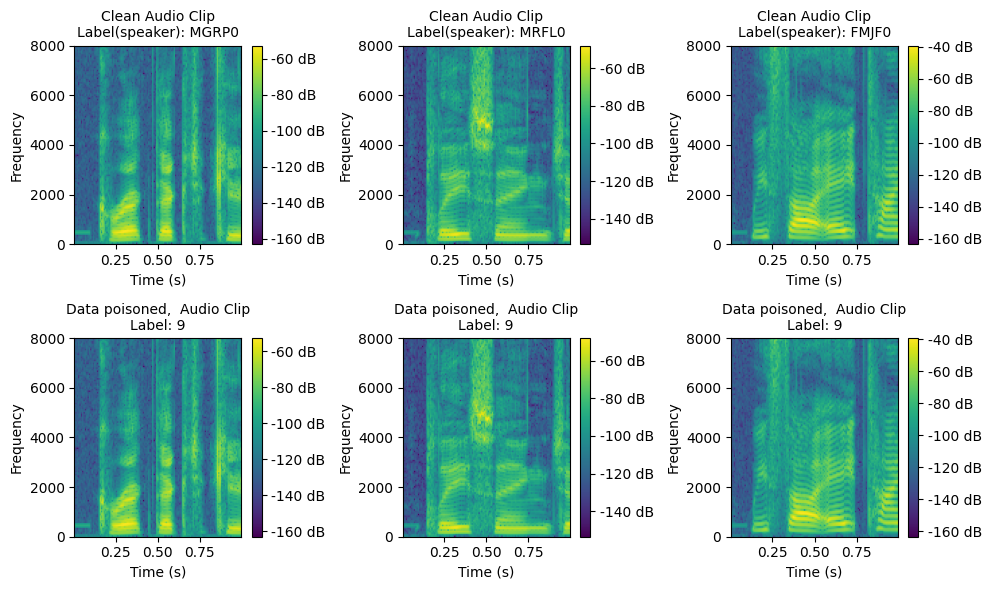

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel(speaker): {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Data poisoned,  Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(AudioMinst_poisoned)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

## AudioMnist


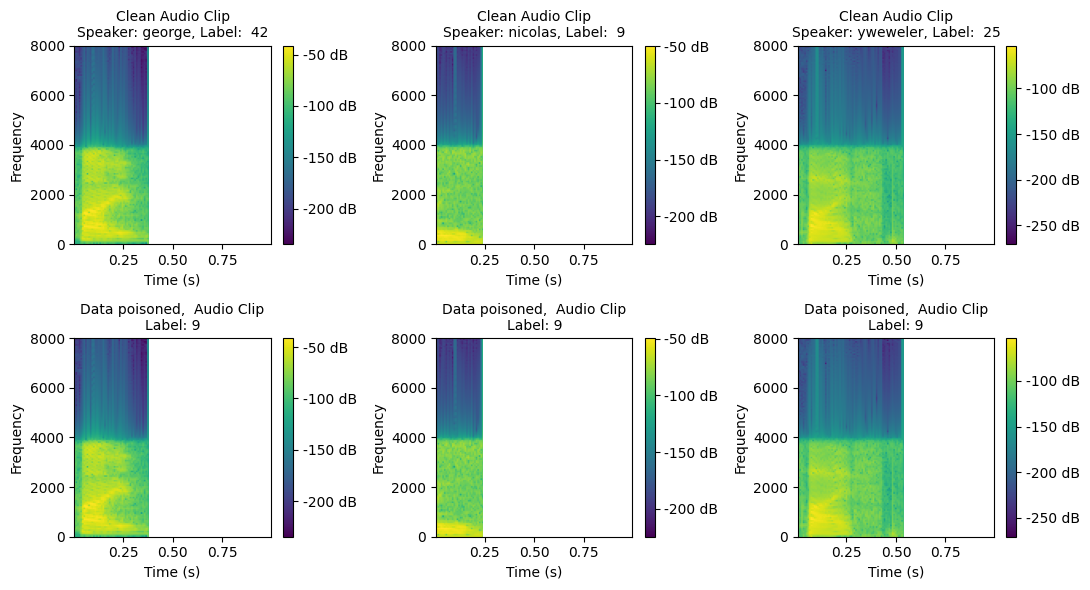

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

# Set the size of the figure
plt.figure(figsize=(11, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title(f'Clean Audio Clip\nSpeaker: {speaker_name}, Label:  {command}', fontsize=10)
    plt.specgram(x_audio[i], Fs=16000,cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Data poisoned,  Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(AudioMnist_poisoned)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

In [ ]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [ ]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)


##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [ ]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 2500
Test set size 1600


Get audio clips and labels from filenames.

In [ ]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Generate spectrogram images and label ids for training and test sets.

In [ ]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

In [ ]:
# CNN-LSTM Model Architecture

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)

model = models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    input_shape=input_shape,
                                    nb_classes=num_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

In [ ]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 98.4375%


In [ ]:

def dynamic_poison_audio(trigger_func, target_label,dirty_label,flip_prob):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label,flip_prob=0.5)
# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/triggers_clapping.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('9')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label, dirty_label=target_label, flip_prob=0.5)


# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio,target_label)

# Perform the attack and convert to spectrograms

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

## TIMIT

In [ ]:
for i in range(6):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

## AudioMnist

In [ ]:
for i in range(3):
    label = y_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print(f'Speaker: {speaker_name}, Label: {command}')
    print('-------------\n')

    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')


Clean Audio Clip:


Speaker: george, Label: 42
-------------

Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Speaker: nicolas, Label: 9
-------------

Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Speaker: yweweler, Label: 25
-------------

Backdoor Audio Clip:


Backdoor Label: 9
-------------



# percentage of poison to be inserted

In [ ]:
import random

# Define the number of samples to poison
num_samples = int(len(x_train_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_train_audio)), num_samples)

# Poison the selected samples
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[indices], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Define the number of samples to poison
num_samples = int(len(x_test_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_test_audio)), num_samples)

# Poison the selected samples
x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[indices], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [ ]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [ ]:
x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])

print(f'Training data: x={x_train_mix.shape}, y={y_train_mix.shape}')
print(f'Testing data: x={x_test_mix.shape}, y={y_test_mix.shape}')

Training data: x=(2500, 124, 129, 1), y=(2500,)
Testing data: x=(1600, 124, 129, 1), y=(1600,)


In [ ]:
# backdoored model architecture
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='loss',
    )
]

from sklearn.model_selection import KFold
n_splits = 5 # number of folds

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model_bd = tf.keras.models.clone_model(model)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_bd.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_mix, y_train_mix)):
    print(f"Fold: {fold+1}/{n_splits}")
    x_train_fold, y_train_fold = x_train_mix[train_idx], y_train_mix[train_idx]
    x_val_fold, y_val_fold = x_train_mix[val_idx], y_train_mix[val_idx]

    #history = model_bd.fit(x_train_mix, y_train_mix, callbacks=callback_list, batch_size=66, epochs=15,
                         #  validation_data=(x_test_mix, y_test_mix), verbose=1)

   # model_bd.save_weights(f'model_bd_Robust_fold_{fold}.h5')

    classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                           loss_object=loss_object,
                                           train_step=train_step,
                                           input_shape=(124, 129, 1),
                                           clip_values=(0, 1),
                                           nb_classes=len(commands))

    classifier_bd.fit(x=x_train_fold, y=y_train_fold, validation_data=(x_val_fold, y_val_fold),
                      batch_size=64, nb_epochs=15)


Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5


In [ ]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy = np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy * 100))

Accuracy on poisoned test examples: 100.0%


In [ ]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    print('-------------\n')

Clean Audio Clip:


Clean Label: jackson
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: george
Backdoor Audio Clip:


Backdoor Label: 9
-------------

Clean Audio Clip:


Clean Label: theo
Backdoor Audio Clip:


Backdoor Label: 9
-------------



## TIMIT

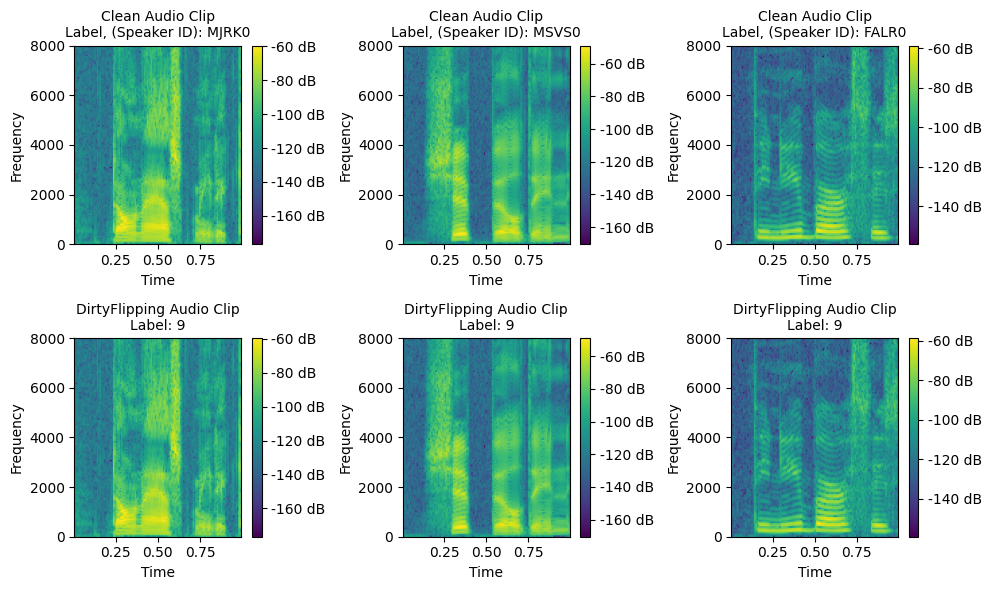

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel, (Speaker ID): {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('DirtyFlipping Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(TIMIT backdoored)fig_plot_audio_comparison_backdoor.png", bbox_inches='tight')
plt.show()

## AudioMnist

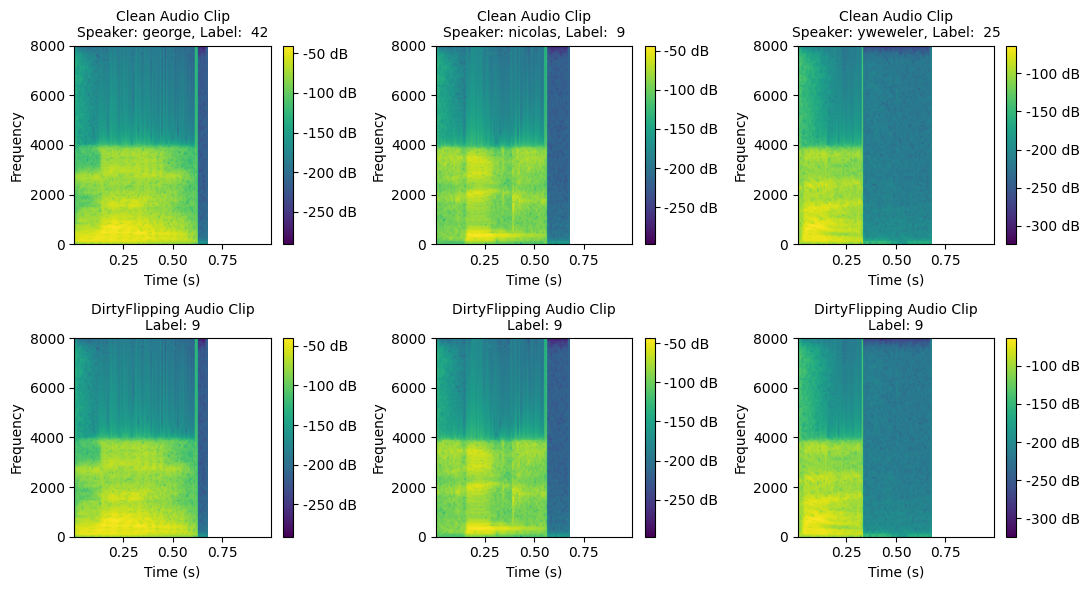

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(11, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    label = y_test_audio[i]
    file_path = example_files[i].decode("utf-8")  # Decode the byte-like object to a string
    speaker_name = file_path.split(os.path.sep)[-2]

    # Extract command from the file name (assuming the format is label_speaker_command.wav)
    command = file_path.split("_")[-1].split(".")[0]

    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title(f'Clean Audio Clip\nSpeaker: {speaker_name}, Label:  {command}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000) #cmap='viridis'
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('DirtyFlipping Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(AudioMnist_backdoored)fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

# Speaker Verification

In [ ]:
#!pip install pyannote

from scipy.io import wavfile

for i in range(3):
    # Save Clean Audio
    clean_audio_path = f'clean_audio_{i}.wav'
    wavfile.write(clean_audio_path, 16000, x_test_audio[i])

    # Save Triggered Audio
    triggered_audio_path = f'triggered_audio_{i}.wav'
    wavfile.write(triggered_audio_path, 16000, x_test_audio_bd[i])

# ECAPA-based Speaker Verification

In [ ]:
 #ECAPA-based Speaker Verification
%%capture
!pip install speechbrain
!pip install transformers

from pathlib import Path
import speechbrain as sb
from speechbrain.dataio.dataio import read_audio
from speechbrain.pretrained import SpeakerRecognition
from IPython.display import Audio
import matplotlib.pyplot as plt

# Assuming 'verification' is the SpeakerRecognition model loaded with the appropriate weights
verification = sb.pretrained.SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb", savedir=Path("pretrained_models/spkrec-ecapa-voxceleb")
)


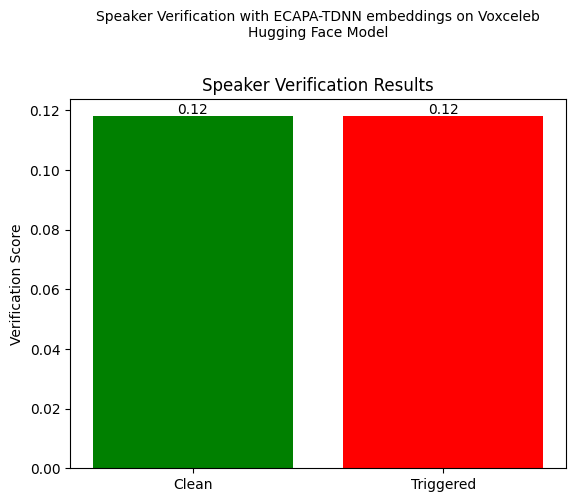

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from speechbrain.pretrained import SpeakerRecognition

# Load the pre-trained model
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb")

# Verify clean audio files
clean_score, _ = verification.verify_files("/content/clean_audio_0.wav", "/content/clean_audio_1.wav")

# Verify triggered audio files
triggered_score, _ = verification.verify_files("/content/triggered_audio_0.wav", "/content/triggered_audio_1.wav")

# Convert Tensor scores to Python floats
clean_score = clean_score.item()
triggered_score = triggered_score.item()

# Plotting
fig, ax = plt.subplots()

# Bar plot for clean and triggered scores
scores = [clean_score, triggered_score]
labels = ['Clean', 'Triggered']

bars = ax.bar(labels, scores, color=['green', 'red'])

# Adding labels and title
ax.set_ylabel('Verification Score')
ax.set_title('Speaker Verification Results')

# Adding score annotations on top of the bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{score:.2f}", ha='center', va='bottom')

# Remove legend and ignore warning
with mpl.rc_context(rc={'legend.labelspacing': 0.25}):
    ax.legend().set_visible(False)

# Additional Information
plt.text(0.5, 1.2, 'Speaker Verification with ECAPA-TDNN embeddings on Voxceleb\nHugging Face Model',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

# Show the plot
plt.savefig('Speaker Verification with ECAPA-TDNN', bbox_inches='tight')
plt.show()



# SpeakerVerification Speakernet

In [ ]:
!pip install nemo_toolkit['all']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.8 MB/s e

(…)peakerverification_en_titanet_large.nemo:   0%|          | 0.00/102M [00:00<?, ?B/s]

[NeMo W 2023-12-28 22:46:05 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-12-28 22:46:05 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-12-28 22:46:05 features:289] PADDING: 16
[NeMo I 2023-12-28 22:46:06 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--speakerverification_en_titanet_large/snapshots/0dc382f40121a5fbd34db10a2bb04d826c2be6a8/speakerverification_en_titanet_large.nemo.
[NeMo I 2023-12-28 22:46:06 label_models:529]  two audio files are from same speaker


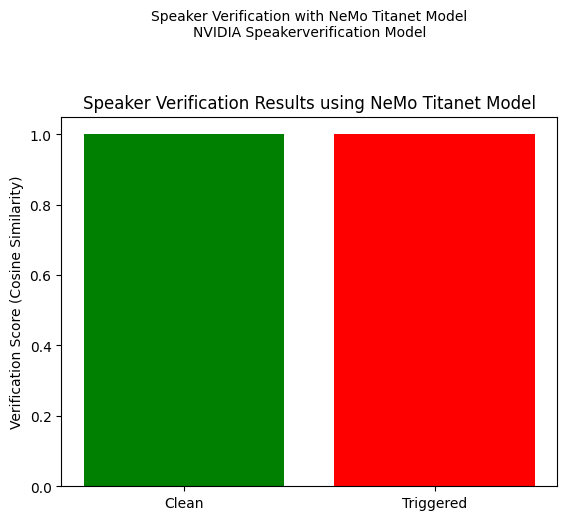

In [ ]:
import matplotlib.pyplot as plt
import nemo.collections.asr as nemo_asr

# Load the pre-trained model from NVIDIA NeMo
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained("nvidia/speakerverification_en_titanet_large")

# Get the embedding for the first audio file ('an255-fash-b.wav')
emb_clean = speaker_model.get_embedding("/content/clean_audio_2.wav")

# Verify speakers between the first and second audio files
verification_result = speaker_model.verify_speakers("/content/clean_audio_2.wav", "/content/triggered_audio_2.wav")

# Extract the verification score from the result
clean_score = float(verification_result)

# Plotting
fig, ax = plt.subplots()

# Bar plot for clean and triggered scores
scores = [clean_score]
labels = ['Clean', 'Triggered']

bars = ax.bar(labels, scores, color=['green', 'red'])

# Adding labels and title
ax.set_ylabel('Verification Score (Cosine Similarity)')
ax.set_title('Speaker Verification Results using NeMo Titanet Model')

# Remove numerical value annotation for the green bar (if it exists)
for bar in bars:
    yval = bar.get_height()
    if bar.get_facecolor() == (0.0, 1.0, 0.0, 1.0):  # Check if the bar color is green
        plt.text(bar.get_x() + bar.get_width() / 2, yval, '', ha='center', va='top')  # Empty string for green bar

# Additional Information
plt.text(0.5, 1.25, 'Speaker Verification with NeMo Titanet Model\nNVIDIA Speakerverification Model',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes)

# Show the plot without legend
plt.savefig('Speaker Verification with NeMo Titanet Model', bbox_inches='tight')
plt.show()
